<a href="https://colab.research.google.com/github/mpg-data/dlthub-education/blob/portable_lake_spanish/Shared_Build_Portable_Data_Lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **<font color='#9EA900'>No more `in the clouds`</font>!**
Let’s break down a portable data lake POC with two key tools:

- [`dlt`](#scrollTo=RR1KEWk7pVRe)
- [`ibis`](#scrollTo=fMcbJicA3061)

---
## **pip <font color='#9EA900'>install</font> <font color='#479AAA'>`dlt`</font>**
---

### **I. <font color='#9EA900'>What's</font> <font color='#479AAA'>`dlt`</font>?**

> An **open-source Python library** that loads data from various, often messy data sources into well-structured, live datasets. It offers a lightweight interface for extracting data from REST APIs, SQL databases, cloud storage, Python data structures, and [many more](https://dlthub.com/docs/intro).

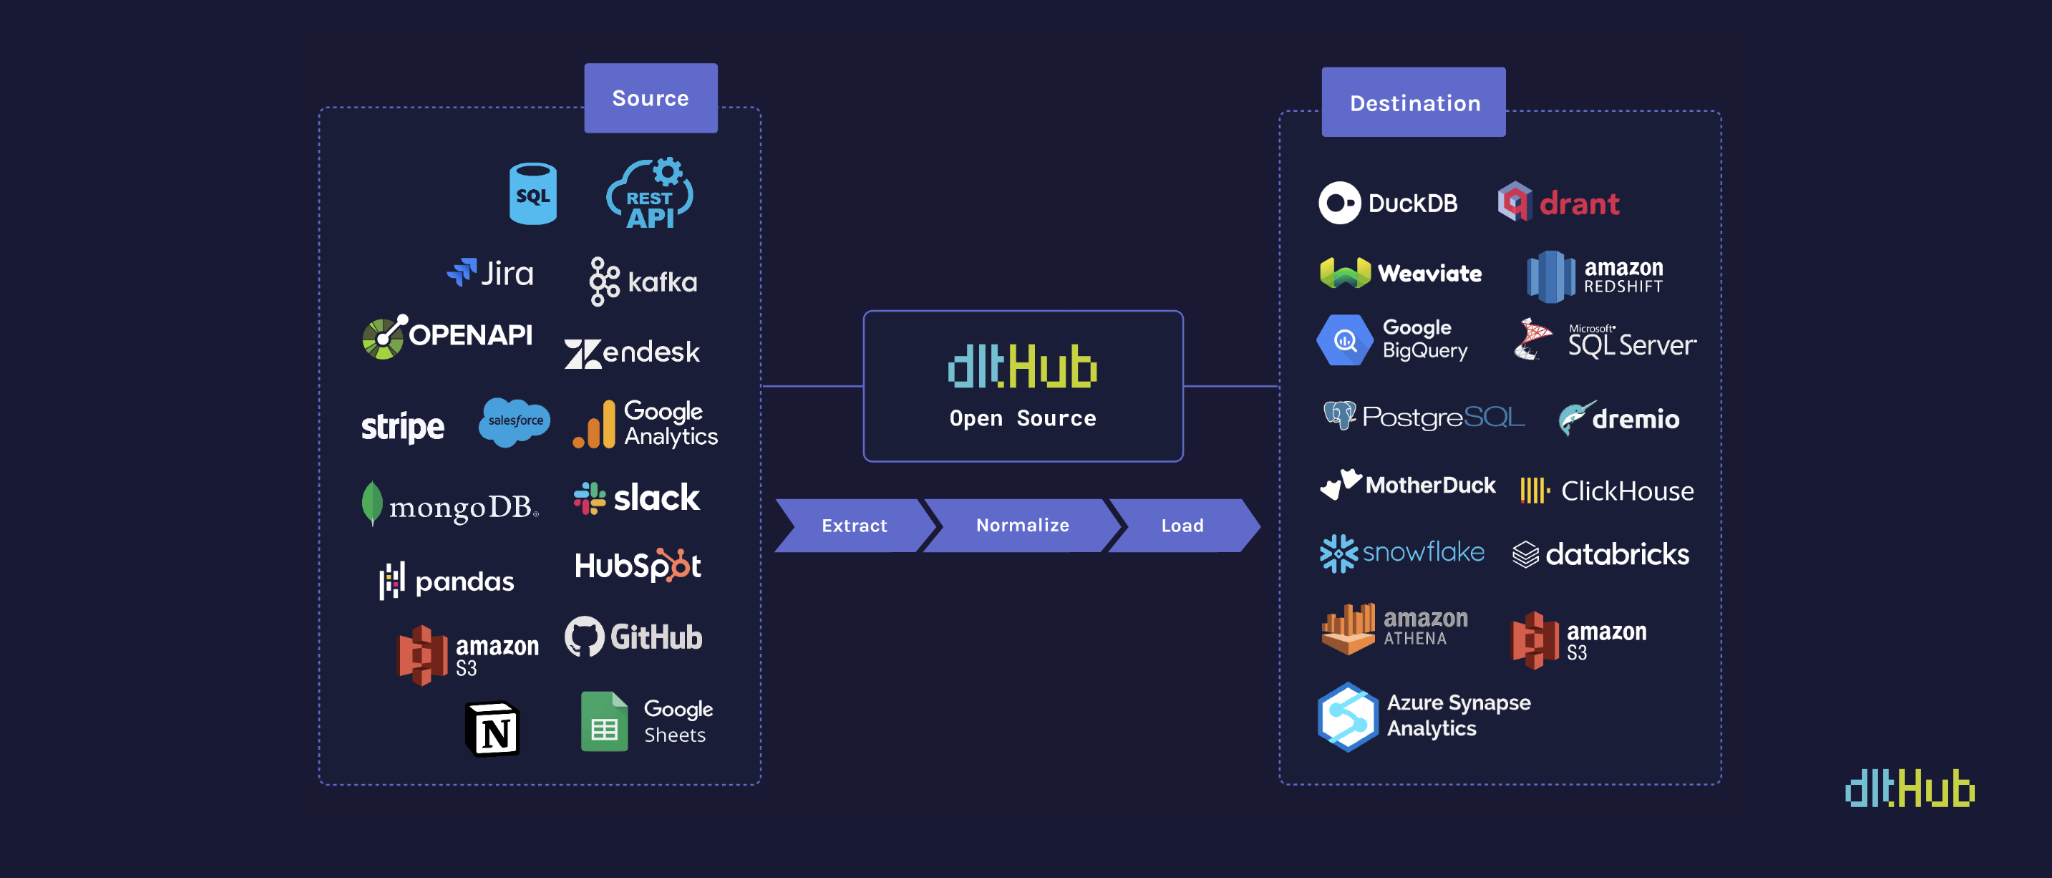

`dlt` contains all DE best practices and handles:
- 🧬 [Schema evolution](https://dlthub.com/docs/general-usage/schema-evolution)
- 🤝 [Data contracts](https://dlthub.com/docs/general-usage/schema-contracts#schema-and-data-contracts)
- 🧠 [Incremental loading](https://dlthub.com/docs/general-usage/incremental-loading)
- 🏃‍♀️ [Performance management](https://dlthub.com/docs/reference/performance)


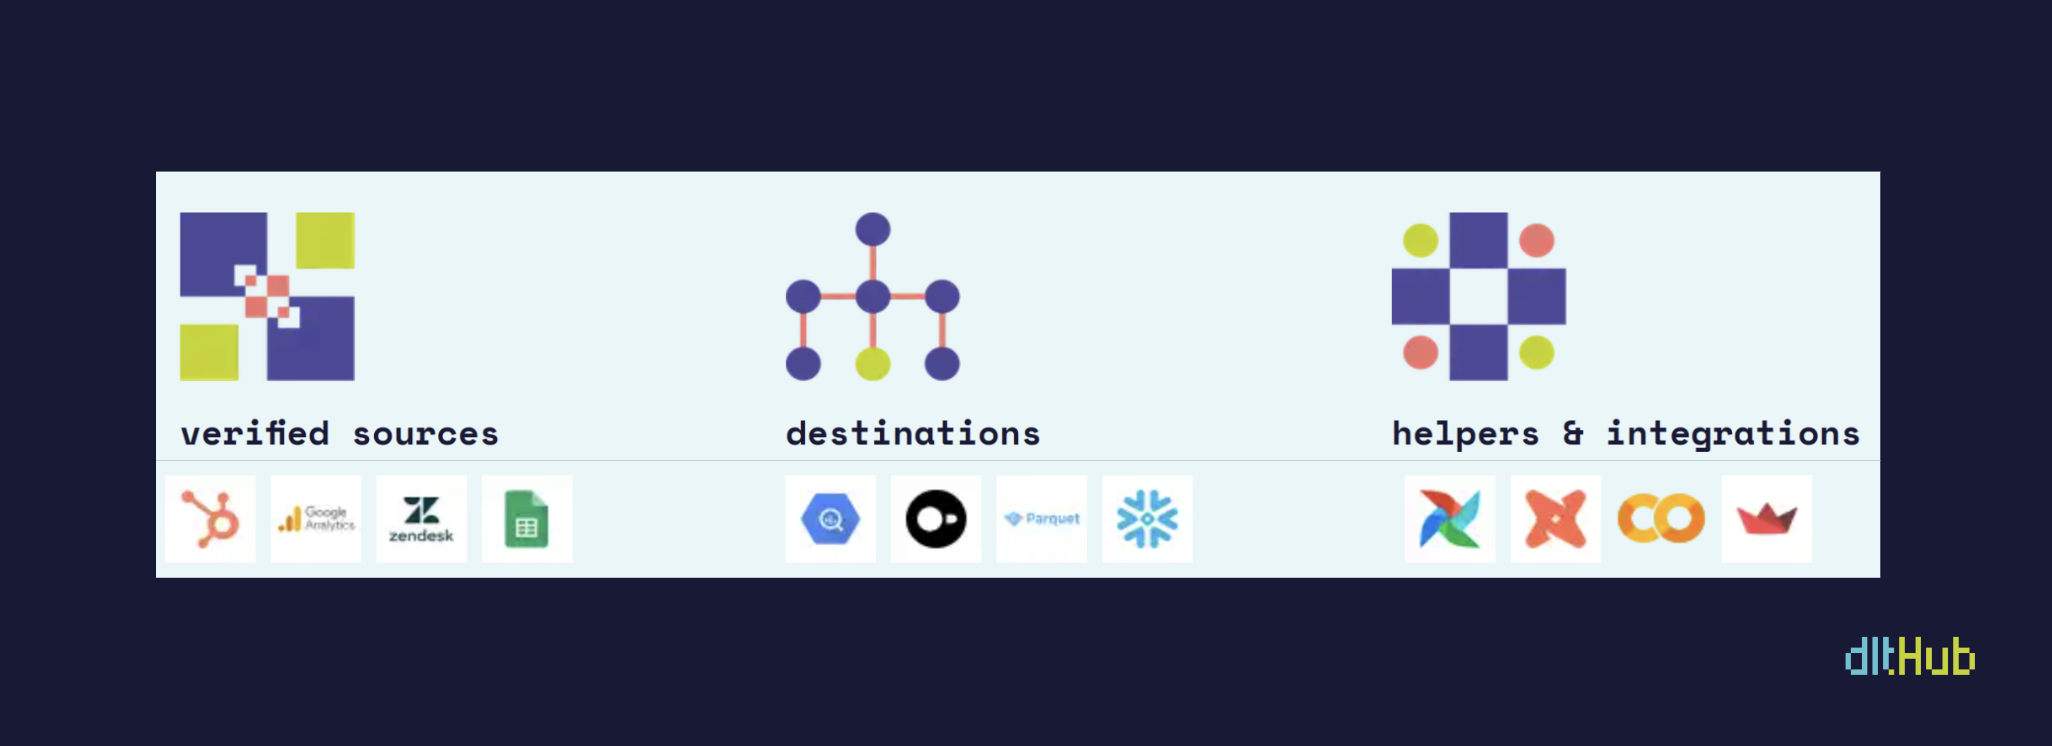

<center>
<pre>
dlt init &lt;your-source&gt; &lt;your-destination&gt;
</pre>
</center>

---
### **II. <font color='#9EA900'>Simple example:</font> Python dict → DuckDB**

**Step 1.** Install `dlt`

In [ ]:
%%capture
!pip install dlt

**Step 2.** Define your `dlt` resource

> A `dlt` resource is a function decorated with `dlt.resource` or `dlt.transformer` that extracts data from a source, such as an API endpoint, SQL database, cloud storage, file, or simple Python data structure, as shown below 👇

In [ ]:
import dlt

@dlt.resource
def foo():
    for i in range(10):
        yield {
            "id": i,
            "name": {
                "first": "Kai",
                "last": "Santos"
            }
        }

**Step 3.** Create your pipeline

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="python_data_example",
    destination="duckdb",
)

**Step 4.** Run your pipeline

In [ ]:
load_info = pipeline.run(foo)
print(load_info)

Pipeline python_data_example load step completed in 1.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset python_data_example_dataset
The duckdb destination used duckdb:////content/python_data_example.duckdb location to store data
Load package 1731067336.8134794 is LOADED and contains no failed jobs


**Step 5.** Check the results

In [ ]:
with pipeline.sql_client() as client:
    with client.execute_query("SELECT * FROM foo") as cursor:
        print(cursor.df())

   id name__first name__last        _dlt_load_id         _dlt_id
0   0         Kai     Santos  1731067336.8134794  6FZnAYtGmCUlww
1   1         Kai     Santos  1731067336.8134794  Ipqnc5RHnD+EmQ
2   2         Kai     Santos  1731067336.8134794  GyeiFog18JLsaQ
3   3         Kai     Santos  1731067336.8134794  BsTiJ0l5m7ymag
4   4         Kai     Santos  1731067336.8134794  XFDp2jjife9VWA
5   5         Kai     Santos  1731067336.8134794  iaOHxa32ERuRxw
6   6         Kai     Santos  1731067336.8134794  56UAwh4gkIfGHw
7   7         Kai     Santos  1731067336.8134794  x5YknOkNSy6hgQ
8   8         Kai     Santos  1731067336.8134794  JD7Y3H72psPkag
9   9         Kai     Santos  1731067336.8134794  Ai/3R5fLkxDKuQ


---
### **III. <font color='#9EA900'>Extended example:</font> GitHub data → Filesystem**

In this example, we load GitHub issues from the dltHub repository to the local filesystem as Parquet files.

All your data will be processed, typed, unnested and loaded in `bucket_url="./data_lake"`.

**Step 1.** Install the necessary dependencies

In [ ]:
%%capture
!pip install dlt pyarrow==17.0.0

In [ ]:
%%capture
!pip install "dlt[deltalake]"

**Step 2.** Define your `dlt` resource

In [ ]:
import os
import dlt
from dlt.sources.helpers import requests

BASE_URL = "https://api.github.com/repos/dlt-hub/dlt"

os.environ["BUCKET_URL"] = "./data_lake"

def pagination(url):
    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(
    table_name="issues",
    write_disposition="replace",
)
def get_issues():
    url = (
        f"{BASE_URL}/issues?per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)

**Step 3.** Define your `dlt` source with your resource

In [ ]:
@dlt.source
def github_source():
    return get_issues()

**Step 4.** Create your pipeline

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_data_lake_raw",
    destination="filesystem",
    dataset_name="github_raw",
)

**Step 5.** Run your pipeline with  `parquet` laoder file format

In [ ]:
load_info = pipeline.run(github_source(), loader_file_format="parquet")
print(load_info)

Pipeline github_data_lake_raw load step completed in 1.33 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_raw
The filesystem destination used file:///content/data_lake location to store data
Load package 1731067373.5926197 is LOADED and contains no failed jobs


**Step 6.** Check info about the last normalization process in the pipeline

In [ ]:
print(pipeline.last_trace.last_normalize_info)

Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- issues: 164 row(s)
- issues__labels: 114 row(s)
- issues__assignees: 66 row(s)
- issues__performed_via_github_app__events: 25 row(s)

Load package 1731067373.5926197 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


**Step 7.** View your data in the `Files` menu on the left side bar. It should looks something like this

<img src="https://storage.googleapis.com/dlt-blog-images/datalake_workshop_filesystem.png" alt="Description" width="400" style="display: block; margin: auto;" />


---
### **III-A. <font color='#9EA900'>File formats</font>**

> **What's a file format?** It defines how data is structured within a file. Each format has its own structure, performance characteristics, and use cases.

In the previous section, we loaded data from GitHub to the local filesystem using `parquet` as the loader file format.

For the filesystem destination, `dlt` supports three file formats:

- `parquet`
- `jsonl`
- `csv`

Just like how we defined `parquet` previously, we can define `csv`:
```python
load_info = pipeline.run(github_source(), loader_file_format="csv")
```

To briefly sum up the differences 👀:

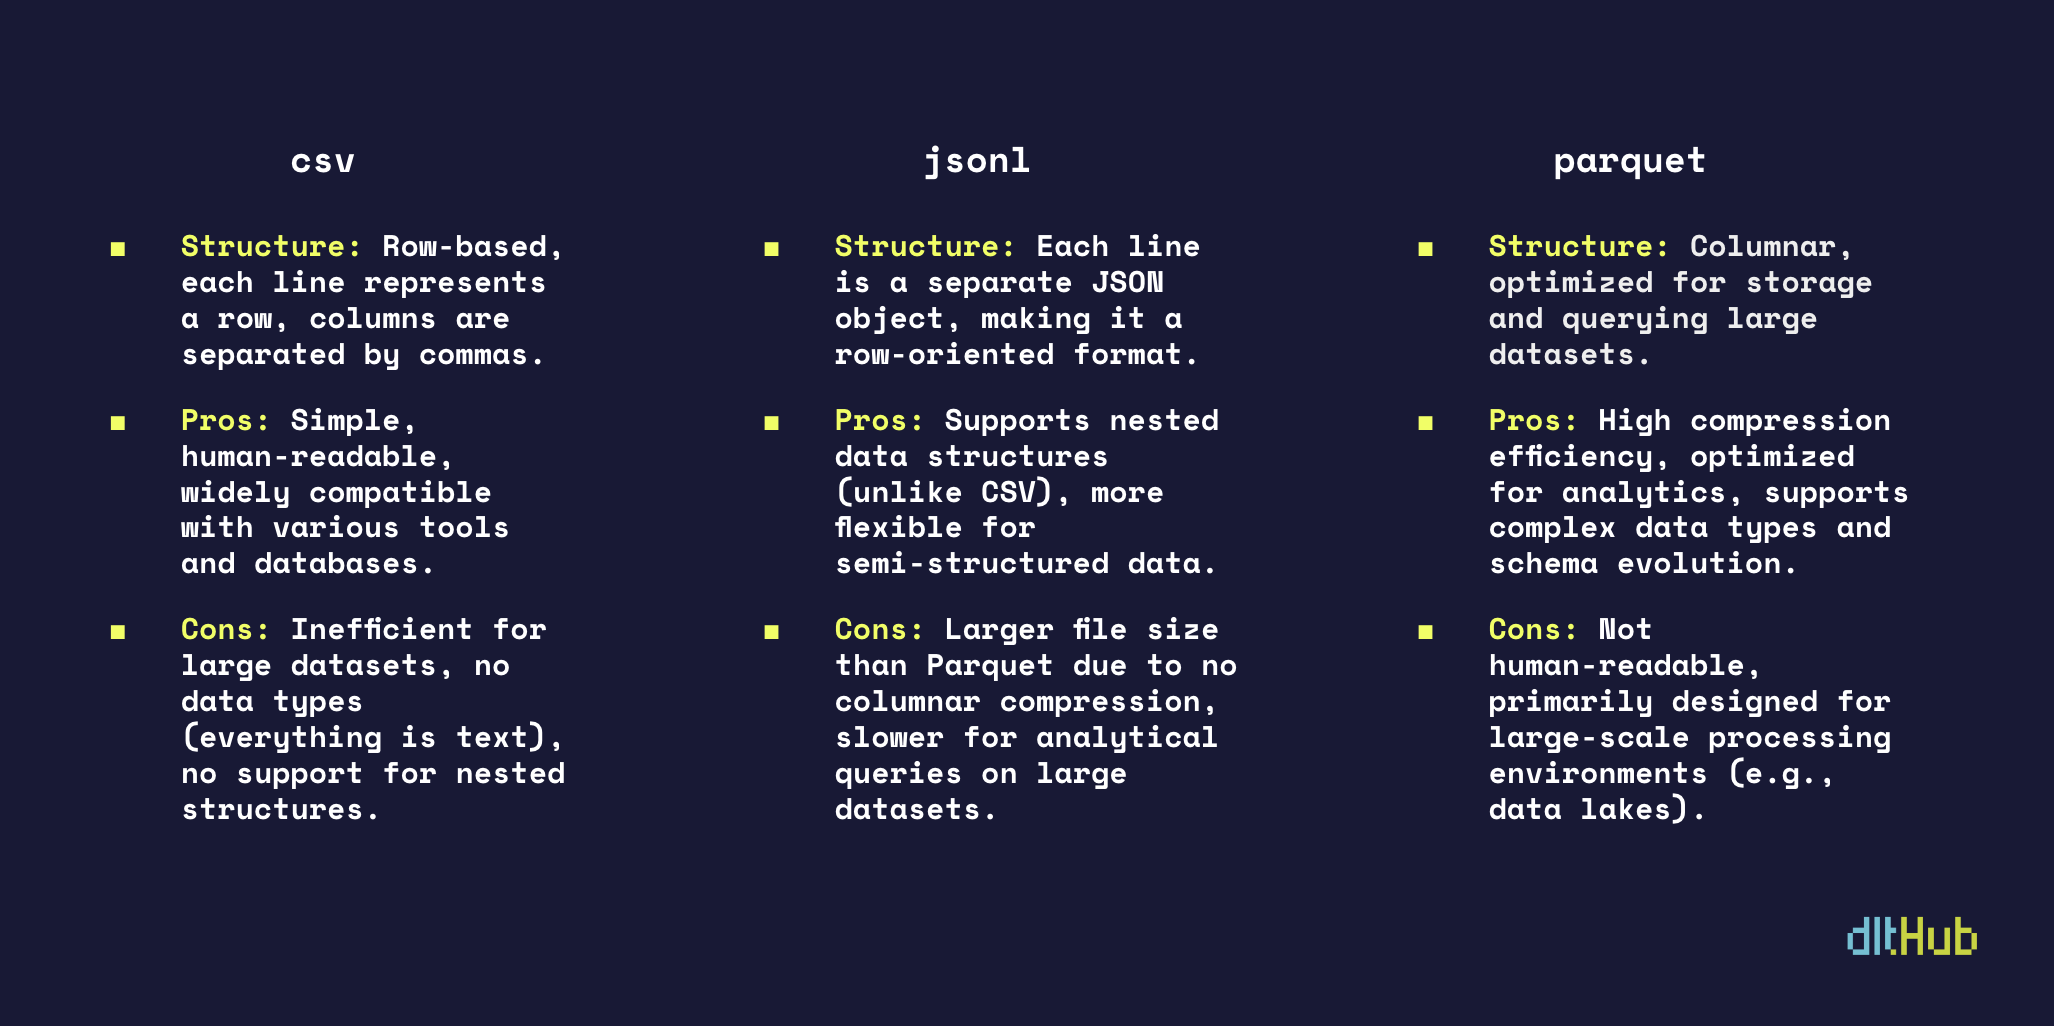

#### **💡 <font color='#479AAA'>Why it matters</font>**

> **TLDR:** Supporting multiple loader file formats allows `dlt` pipelines to adapt to various destinations, making data more portable across platforms.

---
### **III-A. <font color='#9EA900'>Table formats</font>**

> **What's a table format?** It's a data management layer that organizes and tracks data files in a data lake as a logical table. These formats help manage datasets in data lakes, allowing for ACID transactions, time-travel queries, and efficient data retrieval.


#### **<font color='#479AAA'> Δ `Delta` table format</font>**


In the last pipeline, we didn’t specify a table format — but we can!

For the filesystem destination, `dlt` supports the `delta` table format.

Here's how we would do it 👇

**Step 1.** Redefine your `dlt` resource with `delta` as the table format

In [ ]:
@dlt.resource(
    table_name="issues",
    write_disposition="replace",
    table_format="delta"
)
def get_issues():
    url = (
        f"{BASE_URL}/issues?per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)

2024-11-08 12:03:09,193|[WARNING]|442|137573662236672|dlt|source.py|register:572|A source with ref dlt.__main__.get_issues is already registered and will be overwritten


**Step 2.** Rerun your pipeline with `write_disposition` set to `replace`

In [ ]:
load_info = pipeline.run(github_source(), loader_file_format="parquet", write_disposition="replace")
print(load_info)

Pipeline github_data_lake_raw load step completed in 2.11 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_raw
The filesystem destination used file:///content/data_lake location to store data
Load package 1731067391.9039288 is LOADED and contains no failed jobs


**Step 3.** See what has changed. It should look something like this

<img src="https://storage.googleapis.com/dlt-blog-images/datalake_workshop_filesystem_delta.png" alt="Description" width="600" style="display: block; margin: auto;" />


#### **<font color='#479AAA'>🧊 `Iceberg` table format</font>**


`dlt` supports `Iceberg` table format for the Athena destination, with `parquet` as the default loader file format.

>  Setting up `dlt` to interact with Athena
>
>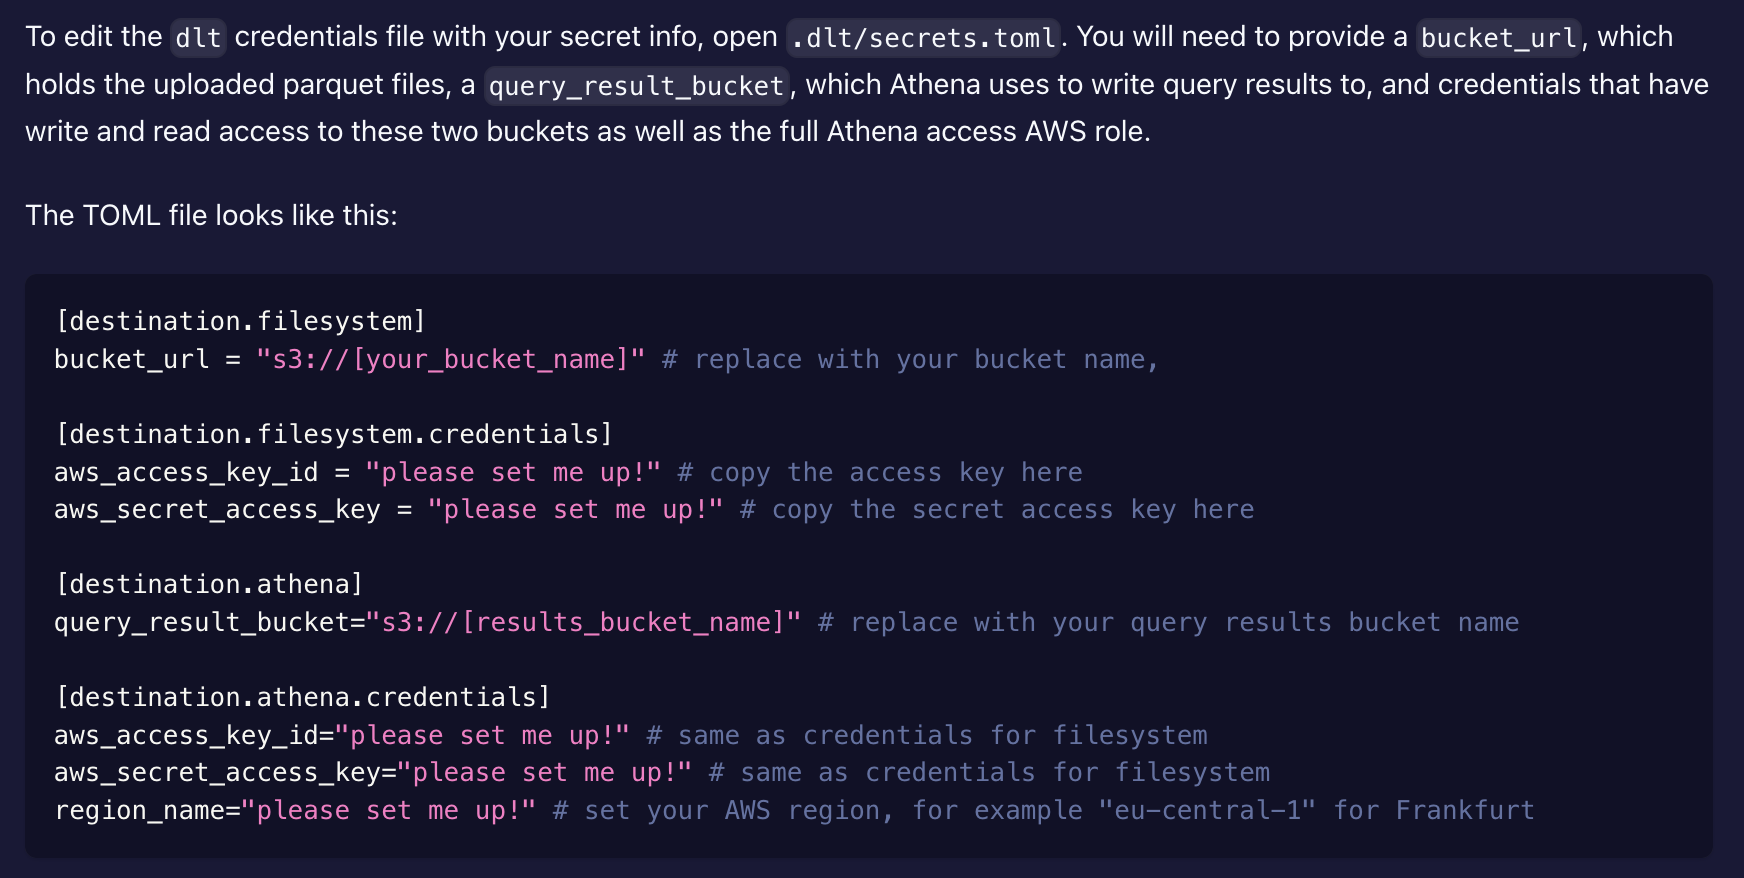

**Step 1.** Install dependencies

In [ ]:
%%capture
pip install "dlt[athena]"

**Step 2.** Set up environment variables, since they are easier to handle in the Colab environment as compared to `.toml` files

In [ ]:
import os
from google.colab import userdata

os.environ["DESTINATION__FILESYSTEM__BUCKET_URL"] = userdata.get("BUCKET_URL") # add your own s3 bucket url

os.environ["DESTINATION__FILESYSTEM__CREDENTIALS__AWS_ACCESS_KEY_ID"] = userdata.get("AWS_ACCESS_KEY_ID") # add your own aws access key id
os.environ["DESTINATION__FILESYSTEM__CREDENTIALS__AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY") # add your own aws secret access key

os.environ["DESTINATION__ATHENA__QUERY_RESULT_BUCKET"] = userdata.get("QUERY_RESULT_BUCKET") # add your own query result bucket

os.environ["DESTINATION__ATHENA__CREDENTIALS__AWS_ACCESS_KEY_ID"] = userdata.get("AWS_ACCESS_KEY_ID") # add your own aws athena access key id
os.environ["DESTINATION__ATHENA__CREDENTIALS__AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY") # add your own aws athena secret access key
os.environ["DESTINATION__ATHENA__CREDENTIALS__REGION_NAME"] = userdata.get("REGION_NAME") # add your own aws region

**Step 3.** Redefine your `dlt` resource with `Iceberg` as the table format

In [ ]:
@dlt.resource(
    table_name="issues",
    write_disposition="replace",
    table_format="iceberg"
)
def get_issues():
    url = (
        f"{BASE_URL}/issues?per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)

2024-11-08 12:12:57,656|[WARNING]|442|137573662236672|dlt|source.py|register:572|A source with ref dlt.__main__.get_issues is already registered and will be overwritten


**Step 4.** Create a new pipeline with the Athena destination

In [ ]:
athena_pipeline = dlt.pipeline(
    pipeline_name="github_data_lake_raw_athena",
    destination="athena",
    dataset_name="github_raw"
)

2024-11-08 12:13:02,495|[WARNING]|442|137573662236672|dlt|pipeline.py|_set_destinations:1366|The destination athena requires the filesystem staging destination to be set, but it was not provided. Setting it to 'filesystem'.


**Step 5.** Run the pipeline

In [ ]:
load_info = athena_pipeline.run(github_source(), loader_file_format="parquet")
print(load_info)

Pipeline github_data_lake_raw_athena load step completed in 1 minute and 54.49 seconds
1 load package(s) were loaded to destination athena and into dataset github_raw
The filesystem staging destination used s3://dlt-athena-output location to stage data
The athena destination used s3://dlt-athena-output on awsdatacatalog location to store data
Load package 1731067986.766057 is LOADED and contains no failed jobs


**Step 6.** See what has happened in S3. It should look something like this

<img src="https://storage.googleapis.com/dlt-blog-images/datalake_workshop_athena.png" alt="Description" width="600" style="display: block; margin: auto;" />


> ☝️ We used the same bucket for staging, so we have both datasets in the same location.

**Step 7.** Confirm the `Iceberg` table format. The table folders should look like this, where `data/` stores the actual data files and `metadata/` contains the versioned metadata files

<img src="https://storage.googleapis.com/dlt-blog-images/datalake_workshop_athena_issues_table.png" alt="Description" width="600" style="display: block; margin: auto;" />


#### **💡 <font color='#479AAA'>Why it matters</font>**


>   **TLDR:** Table formats like Iceberg provide data management features that ensure consistency and efficient access for concurrent, multi-platform use.

 **PS:** Right now, a lot of `Iceberg`’s features are only available through specific vendors. `Delta` is different, and we fully support it everywhere. We plan to add early access for `Iceberg` in December, with full support by early Q1 2025.

---
## **pip <font color='#9EA900'>install</font> `ibis`**
---

### **I. <font color='#9EA900'>What's</font> `ibis`?**


> **🤓 By definition**, [`Ibis`](https://ibis-project.org/) is the portable Python dataframe library.
>
> **🤔 In other words**, it makes querying data simple — `you write the code once, and it works on multiple systems`.
>
> **☁️ Metaphorically**, it's like a `universal adapter` for querying data — connecting to any system without locking you in.

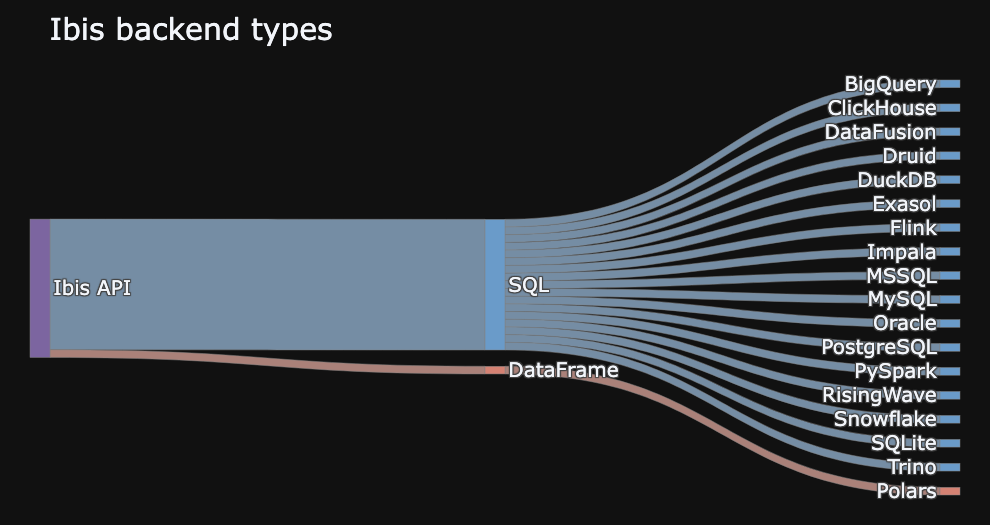

> ⚡ Use the same `ibis` API for 20+ backends.
>
> ⏩ Run fast local dataframes with DuckDB (default), Polars, DataFusion, or PySpark.
>
> 🚛 Develop locally, deploy remotely with one line change.
>
> 🤝 Combine SQL and Python DataFrame operations to bridge data engineering and data science.

---
### **II. <font color='#9EA900'>Simple example:</font> DuckDB backend**

Let's read `parquet` files we loaded earlier to the local filesystem with `ibis`.

**Step 1.** Install `ibis`

In [ ]:
%%capture
!pip install ibis-framework

**Step 2.** Use `ibis`'s default DuckDB backend to read your `parquet` file. DuckDB efficiently reads only the metadata, allowing `read_parquet` to create a lazy view for building expressions without full download.

> Don't forget to replace the path with the correct path.

In [ ]:
import ibis

table = ibis.read_parquet(
  "/content/data_lake/github_raw/issues/1730895258.9747627.37aff27401.parquet"
)
table

DatabaseTable: ibis_read_parquet_x6reukdiivdx5avyslucdaekai
  url                                                        string
  repository_url                                             string
  labels_url                                                 string
  comments_url                                               string
  events_url                                                 string
  html_url                                                   string
  id                                                         int64
  node_id                                                    string
  number                                                     int64
  title                                                      string
  user__login                                                string
  user__id                                                   int64
  user__node_id                                              string
  user__avatar_url                                           string
  user__gravatar_id                                          string
  user__url                                                  string
  user__html_url                                             string
  user__followers_url                                        string
  user__following_url                                        string
  user__gists_url                                            string
  user__starred_url                                          string
  user__subscriptions_url                                    string
  user__organizations_url                                    string
  user__repos_url                                            string
  user__events_url                                           string
  user__received_events_url                                  string
  user__type                                                 string
  user__user_view_type                                       string
  user__site_admin                                           boolean
  state                                                      string
  locked                                                     boolean
  assignee__login                                            string
  assignee__id                                               int64
  assignee__node_id                                          string
  assignee__avatar_url                                       string
  assignee__gravatar_id                                      string
  assignee__url                                              string
  assignee__html_url                                         string
  assignee__followers_url                                    string
  assignee__following_url                                    string
  assignee__gists_url                                        string
  assignee__starred_url                                      string
  assignee__subscriptions_url                                string
  assignee__organizations_url                                string
  assignee__repos_url                                        string
  assignee__events_url                                       string
  assignee__received_events_url                              string
  assignee__type                                             string
  assignee__user_view_type                                   string
  assignee__site_admin                                       boolean
  comments                                                   int64
  created_at                                                 timestamp('UTC', 6)
  updated_at                                                 timestamp('UTC', 6)
  author_association                                         string
  draft                                                      boolean
  pull_request__url                                          string
  pull_request__html_url                                     string
  pull_request__diff_url               

**Step 3.** Query your table: filter for open issues and group by user

In [ ]:
open_issues = table.filter(table.state == 'open')
open_issues_df = open_issues.execute()

issue_counts = open_issues.group_by('user__login').count()
issue_counts_df = issue_counts.execute()

print("Issues Count by User:\n")
issue_counts_df

Issues Count by User:



,user__login,CountStar()
0,steinitzu,3
1,willi-mueller,7
2,23rdPro,1
3,rudolfix,48
4,jorritsandbrink,10
5,deanja,1
6,boxydog,4
7,senickel,1
8,Hasan-J,1
9,ahnazary,1


---
### **III. <font color='#9EA900'>Extended example:</font> Multiple backends**

You can [work with multiple backends](https://ibis-project.org/how-to/input-output/multiple-backends) by creating and using separate connections.

As mentioned, `ibis` uses DuckDB as the default backend. Let’s also try Polars and BigQuery.

#### **<font color='#479AAA'>🐻‍❄️ `Polars`</font>**


> **Why Polars?** It's a high-speed, DataFrame-optimized library written in Rust, ideal for efficient data processing.

**Step 1.** Define `Polars` as the backend

In [ ]:
pl_con = ibis.polars.connect()

**Step 2.** Use `ibis`'s `Polars` backend to read your parquet file

> Don't forget to replace the path with the correct path.

In [ ]:
table = pl_con.read_parquet(
  "/content/data_lake/github_raw/issues/1730895258.9747627.37aff27401.parquet"
)
table

DatabaseTable: ibis_read_parquet_cegq4zju5nekzggnokft7henqa
  url                                                        string
  repository_url                                             string
  labels_url                                                 string
  comments_url                                               string
  events_url                                                 string
  html_url                                                   string
  id                                                         int64
  node_id                                                    string
  number                                                     int64
  title                                                      string
  user__login                                                string
  user__id                                                   int64
  user__node_id                                              string
  user__avatar_url                                           string
  user__gravatar_id                                          string
  user__url                                                  string
  user__html_url                                             string
  user__followers_url                                        string
  user__following_url                                        string
  user__gists_url                                            string
  user__starred_url                                          string
  user__subscriptions_url                                    string
  user__organizations_url                                    string
  user__repos_url                                            string
  user__events_url                                           string
  user__received_events_url                                  string
  user__type                                                 string
  user__user_view_type                                       string
  user__site_admin                                           boolean
  state                                                      string
  locked                                                     boolean
  assignee__login                                            string
  assignee__id                                               int64
  assignee__node_id                                          string
  assignee__avatar_url                                       string
  assignee__gravatar_id                                      string
  assignee__url                                              string
  assignee__html_url                                         string
  assignee__followers_url                                    string
  assignee__following_url                                    string
  assignee__gists_url                                        string
  assignee__starred_url                                      string
  assignee__subscriptions_url                                string
  assignee__organizations_url                                string
  assignee__repos_url                                        string
  assignee__events_url                                       string
  assignee__received_events_url                              string
  assignee__type                                             string
  assignee__user_view_type                                   string
  assignee__site_admin                                       boolean
  comments                                                   int64
  created_at                                                 timestamp('UTC', 6)
  updated_at                                                 timestamp('UTC', 6)
  author_association                                         string
  draft                                                      boolean
  pull_request__url                                          string
  pull_request__html_url                                     string
  pull_request__diff_url               

**Step 3.** Verify that the `Polars` backend is in use

In [ ]:
ibis.get_backend(table)

#### **<font color='#479AAA'>🔍 `BigQuery`</font>**


> **Why BigQuery?** It's cloud-based, built for large-scale production use, and enables fast, scalable data processing.

**Step 1.** Install necessary dependencies

In [ ]:
%%capture
!pip install 'ibis-framework[bigquery]'

**Step 2.** Load credentials from Google Secrets

In [ ]:
import json
import google.auth
from google.oauth2 import service_account
from google.colab import userdata

creds_json = userdata.get('BIGQUERY_CREDENTIALS')
creds_dict = json.loads(creds_json)

# Create Google Cloud credentials from the dictionary
credentials = service_account.Credentials.from_service_account_info(creds_dict)

**Step 3.** Define `BigQuery` as the backend

In [ ]:
bq_con = ibis.bigquery.connect(
    project_id="dlthub-sandbox",
    dataset_id="data_lake_workshop",
    credentials=credentials
)

**Step 4.** Use `ibis`'s `BigQuery` backend to read your parquet file

> Don't forget to replace the path with the correct path.

In [ ]:
table = bq_con.read_parquet(
  "/content/data_lake/github_raw/issues/1730895258.9747627.37aff27401.parquet"
)
table

DatabaseTable: dlthub-sandbox._c7c542770810f6ac191e9b4823c522762da1c34f.ibis_bq_read_PARQUET_qccq6khewbh7leuiuu3uvg7ihi
  url                                                        string
  repository_url                                             string
  labels_url                                                 string
  comments_url                                               string
  events_url                                                 string
  html_url                                                   string
  id                                                         int64
  node_id                                                    string
  number                                                     int64
  title                                                      string
  user__login                                                string
  user__id                                                   int64
  user__node_id                                              string
  user__avatar_url                                           string
  user__gravatar_id                                          string
  user__url                                                  string
  user__html_url                                             string
  user__followers_url                                        string
  user__following_url                                        string
  user__gists_url                                            string
  user__starred_url                                          string
  user__subscriptions_url                                    string
  user__organizations_url                                    string
  user__repos_url                                            string
  user__events_url                                           string
  user__received_events_url                                  string
  user__type                                                 string
  user__user_view_type                                       string
  user__site_admin                                           boolean
  state                                                      string
  locked                                                     boolean
  assignee__login                                            string
  assignee__id                                               int64
  assignee__node_id                                          string
  assignee__avatar_url                                       string
  assignee__gravatar_id                                      string
  assignee__url                                              string
  assignee__html_url                                         string
  assignee__followers_url                                    string
  assignee__following_url                                    string
  assignee__gists_url                                        string
  assignee__starred_url                                      string
  assignee__subscriptions_url                                string
  assignee__organizations_url                                string
  assignee__repos_url                                        string
  assignee__events_url                                       string
  assignee__received_events_url                              string
  assignee__type                                             string
  assignee__user_view_type                                   string
  assignee__site_admin                                       boolean
  comments                                                   int64
  created_at                                                 timestamp('UTC')
  updated_at                                                 timestamp('UTC')
  author_association                                         string
  draft                                                      boolean
  pull_request__url                                          string
  pull_request__html_url                             

**Step 5.** Verify that the `BigQuery` backend is in use

In [ ]:
ibis.get_backend(table)

#### **💡 <font color='#479AAA'>Why it matters</font>**

> **TLDR:** `ibis` provides a unified querying experience across diverse backends, enabling data processing without platform-specific rewrites.

---
## **<font color='#9EA900'>Midway summary:</font> How it all fits together**
___


> Supporting different **<font color='#8e7cc3'>open-source file formats</font>**, reliable **<font color='#ffab40'>open-source table structures</font>**, and a **<font color='#eb5963'>unified open-source query tool</font>** makes data lakes more flexible and portable. Together, these elements ensure data can be easily moved, managed, and queried across different platforms without proprietary limitations.

---
## **<font color='#9EA900'>Local development</font>**
---


### **I. <font color='#9EA900'>Why do we need a local workflow/environment? 🤔</font>**



- A good system should have safeguards preventing direct deployment to production, ensuring quality and safety.
- Testing in cloud environments can be complex. Think, *airflow pipeline local testing on Docker* type complex.
- Tools like DuckDB and Dagster are valued for enabling easy local development and testing environments.

---
### **II. <font color='#9EA900'>Task: Find the number of open issues for each user 🔍</font>**



#### **<font color='#479AAA'> Here are the steps to take:</font>**


1. Read the issues from storage.
2. Apply the transformation to the loaded issues.
3. Feed the transformed data back to the storage.
4. Important: Test the resource by loading it into the development storage area instead of the production storage.

For now in our use case, we are assuming the storage to be a local filesystem.

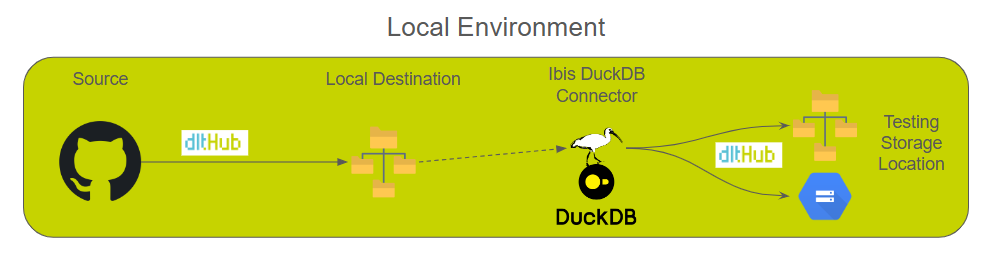

**Steps 1-2.** Read and transform the issues data in a `dlt` resource

In [ ]:
import ibis
import dlt
from dlt.sources.filesystem import filesystem

os.environ["BUCKET_URL"] = "./data_lake"
os.environ["GITHUB_DATA_LAKE_IBIS__SCHEMA__NAMING"] = "direct"


@dlt.resource(table_name="issues_count_by_user")
def transform_issues():
    # Define the path to your Parquet files
    issues_table_filepath = "/content/data_lake/github_raw/issues/1730891979.5375893.b9a38007c0.parquet"

    # Reading from storage: load the Parquet files into an Ibis table
    table = ibis.read_parquet(issues_table_filepath)

    # Or use Polars as a local backend
    # pl_con = ibis.polars.connect()
    # table = pl_con.read_parquet(issues_table_filepath)

    open_issues = table.filter(table.state == 'open')
    open_issues_df = open_issues.execute()

    issue_counts = open_issues.group_by('user__login').count()
    issue_counts_df = issue_counts.execute()
    print("Issues Count by User:\n", issue_counts_df)

    yield issue_counts_df

**Steps 3-4.** Test the resource by ingesting it back into local development storage with `dlt`

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name="github_data_lake_ibis",
    destination="filesystem",
    dataset_name="github_transformed_ibis",
)

load_info = pipeline.run(transform_issues())
print(pipeline.last_trace.last_normalize_info)
print(load_info)

Issues Count by User:
          user__login  CountStar()
0          steinitzu            3
1      willi-mueller            7
2            23rdPro            1
3           rudolfix           48
4    jorritsandbrink           10
5             deanja            1
6            boxydog            4
7           senickel            1
8            Hasan-J            1
9           ahnazary            1
10         phillem15            1
11     paul-godhouse            1
12    alex-fedorenk0            1
13  AstrakhantsevaAA            2
14           rahuljo            1
15           vivingo            1
16          adrianbr            6
17          g-kannan            1
18          Nintorac            1
19           cwe5590            1
20         donotpush            1
21     andrejakobsen            1
22           perttus            1
23        khoadaniel            1
24          redicane            1
25           burnash           10
26         devcovato            1
27       flaviobrito     

---
## **<font color='#9EA900'>Online workflow</font>**
---

### **I. <font color='#9EA900'>Think production🎉</font> (and more)!!**


We were able to work with our Parquet files pretty easily, which also makes it easy to use local storage systems like DuckDB.

*But* once we get to production, things aren't local anymore. Even before going live, we need others to review our work to make sure it actually makes sense!

Moving online helps us:
- share our work
- handle bigger data sets
- and eventually get everything ready for production!

---
### **II. <font color='#9EA900'>Task: Find the number of open issues for each user 🔍</font>**

We repeat the same workflow, but expand it to include online destinations. This is a much more "real life" example since most often than not, our data will be stored in the cloud ☁️



#### **<font color='#479AAA'> Here are the steps to take:</font>**

1. Set up **cloud** storage.
2. Read the issues from **cloud** storage.
3. Apply the transformation to the loaded issues.
4. Feed the transformed data back to the **cloud** storage.



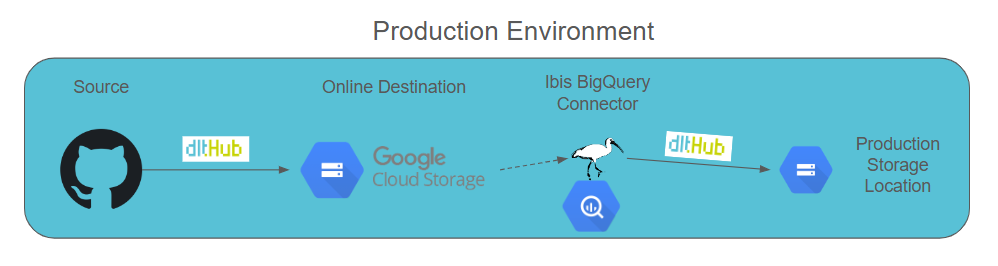

>  Setting up `dlt` to interact with Google Cloud Storage
>
> 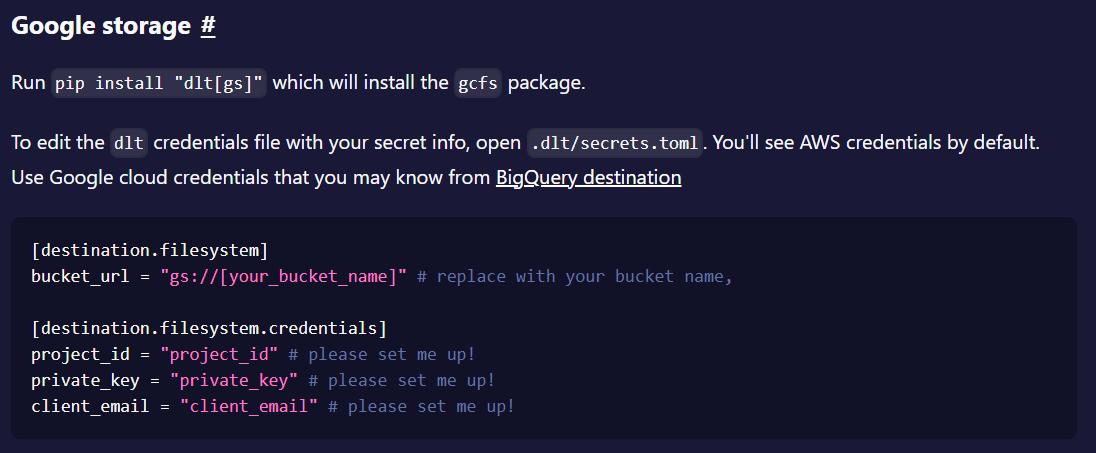

**Step 1-A.** Install dependencies

In [ ]:
%%capture
!pip install "dlt[gs]"

**Step 1-B.** Set up environment variables, since they are easier to handle in the Colab environment as compared to `.toml` files

In [ ]:
import os
from google.colab import userdata

os.environ["DESTINATION__FILESYSTEM__BUCKET_URL"] = "gs://portable_data_lake" # add your own bucket name
os.environ["DESTINATION__FILESYSTEM__CREDENTIALS__PROJECT_ID"] = "dlthub-sandbox" # add your own project id
os.environ["DESTINATION__FILESYSTEM__CREDENTIALS__PRIVATE_KEY"] = userdata.get("PRIVATE_KEY") # add your own private key
os.environ["DESTINATION__FILESYSTEM__CREDENTIALS__CLIENT_EMAIL"] = userdata.get("CLIENT_EMAIL") # add your own service account email

**Step 1-C.** Put some data in **cloud** storage

> This is the exact same data we loaded before into our local filesystem. But now that we have configured GC credentials, `dlt` will create our dataset in the online bucket.

In [ ]:
import os
import dlt
from dlt.sources.helpers import requests

BASE_URL = "https://api.github.com/repos/dlt-hub/dlt"


def pagination(url):
    while True:
        response = requests.get(url)
        response.raise_for_status()
        yield response.json()

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(
    table_name="issues",
    write_disposition="replace",
)
def get_issues():
    url = (
        f"{BASE_URL}/issues?per_page=100&sort=updated"
        "&directions=desc&state=open"
    )
    yield pagination(url)


@dlt.source
def github_source():
    return get_issues()



pipeline = dlt.pipeline(
    pipeline_name="github_data_lake_raw",
    destination="filesystem",
    dataset_name="github_raw",
)

load_info = pipeline.run(github_source(), loader_file_format="parquet")
print(pipeline.last_trace.last_normalize_info)
print(load_info)

Normalized data for the following tables:
- issues: 161 row(s)
- issues__labels: 117 row(s)
- issues__assignees: 68 row(s)
- issues__performed_via_github_app__events: 25 row(s)

Load package 1730902428.7586668 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs
Pipeline github_data_lake_raw load step completed in 14.34 seconds
1 load package(s) were loaded to destination filesystem and into dataset github_raw
The filesystem destination used gs://portable_data_lake location to store data
Load package 1730902428.7586668 is LOADED and contains no failed jobs


After this pipeline runs, we see the resulting dataset created in **cloud** storage.


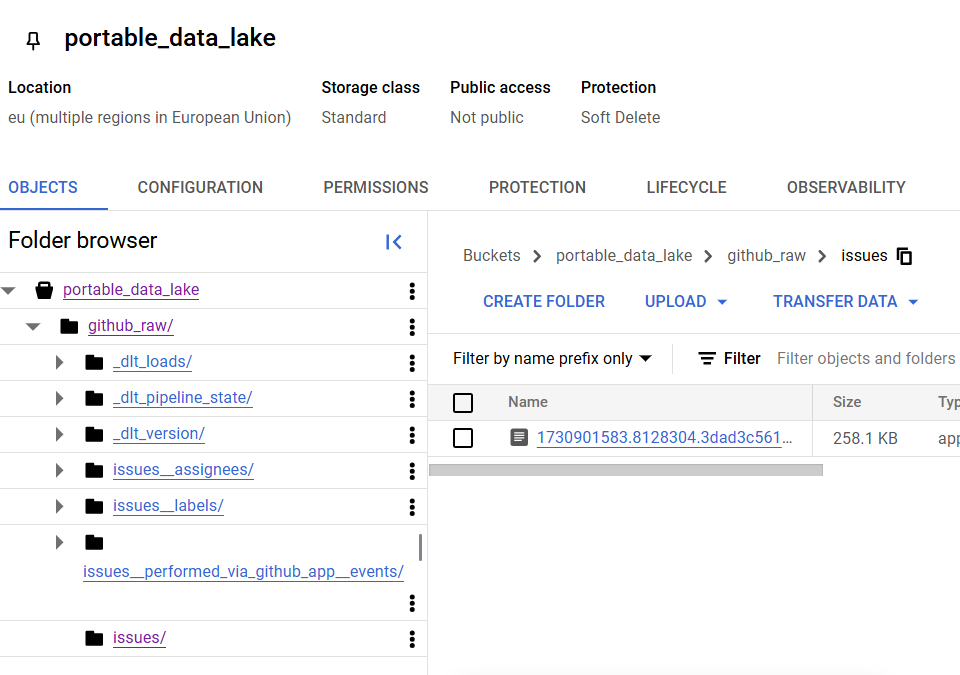

**Step 2-4.** Read and transform the issues data in a `dlt` resource and ingest it back into **cloud** storage ⛅️

In [ ]:
import ibis
import dlt
import json
import google.auth
from dlt.sources.filesystem import filesystem
from google.oauth2 import service_account
from google.colab import userdata

os.environ["GITHUB_DATA_LAKE_IBIS__SCHEMA__NAMING"] = "direct"

creds_json = userdata.get('BIGQUERY_CREDENTIALS')
creds_dict = json.loads(creds_json)

# Create Google Cloud credentials from the dictionary
credentials = service_account.Credentials.from_service_account_info(creds_dict)


@dlt.resource(table_name="issues_count_by_user")
def transform_issues_online():
    # Define the path to your Parquet files
    issues_table_filepath = "gs://portable_data_lake/github_raw/issues/1730902428.7586668.2b861b0808.parquet"

    # Read the Parquet files into an Ibis table
    bq_con = ibis.bigquery.connect(
        project_id="dlthub-sandbox",
        dataset_id="data_lake_workshop",
        credentials=credentials
    )
    table = bq_con.read_parquet(issues_table_filepath)

    open_issues = table.filter(table.state == 'open')
    open_issues_df = open_issues.execute()

    issue_counts = open_issues.group_by('user__login').count()
    issue_counts_df = issue_counts.execute()
    print("Issues Count by User:\n", issue_counts_df)

    yield issue_counts_df



pipeline = dlt.pipeline(
    pipeline_name="github_data_lake_ibis",
    destination="filesystem",
    dataset_name="github_transformed_ibis",
)

load_info = pipeline.run(transform_issues_online())
print(pipeline.last_trace.last_normalize_info)
print(load_info)


2024-11-06 14:16:00,071|[WARNING]|217|140252481798144|dlt|source.py|register:572|A source with ref dlt.__main__.transform_issues_online is already registered and will be overwritten


Issues Count by User:
          user__login  CountStar()
0            boxydog            4
1       Javeed-Pasha            1
2          dat-a-man            1
3     alex-fedorenk0            1
4          erik-meko            1
5         toanlekafi            1
6         marius-sb1            2
7        SeppBerkner            2
8            vivingo            1
9           rudolfix           48
10           Hasan-J            1
11           23rdPro            1
12           perttus            1
13     neuromantik33            1
14       flaviobrito            1
15         steinitzu            3
16           armetiz            1
17             sh-rp           17
18         pulsar256            1
19          Nintorac            1
20           burnash           10
21         donotpush            1
22           rahuljo            1
23     andrejakobsen            1
24  AstrakhantsevaAA            2
25           azngeek            2
26     willi-mueller            7
27          g-kannan     

Our transformed data is now online too! 🥳

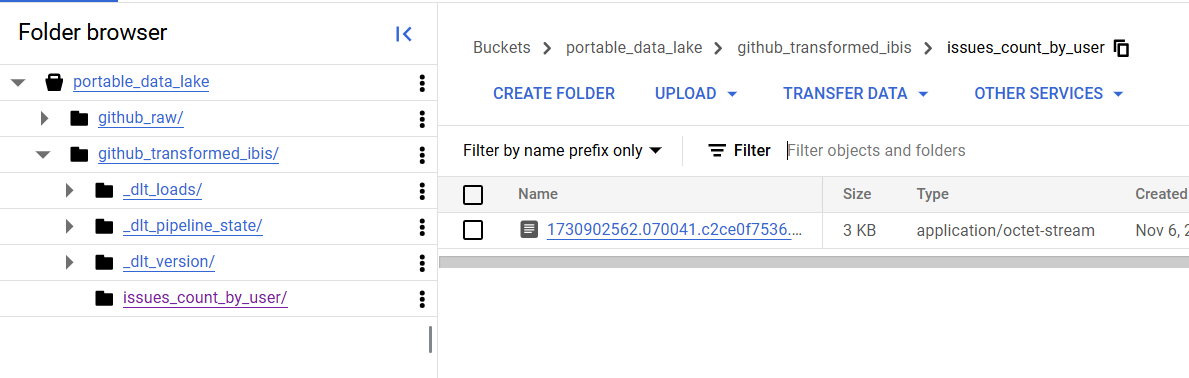

---
## **<font color='#9EA900'>Recap and big picture</font>**
---

There are many ongoing discussions around topics such as:

- **The Composable Data Stack**: Focused on key aspects like interoperability, portability, and flexibility.
- **The Modular Data Stack**: Involving choices like the language used to access data (e.g., Pandas or SQL), the underlying data/file/table formats, and the execution and computation of queries.
- **Open Standards and Open Compute**: Centered on interoperability and avoiding vendor lock-in, which aligns closely with the goals of a lot of the things we discussed today.

This workshop and demo aim to guide you in building a 'portable data lake' that enables you to apply all these concepts effectively. To recap, this includes workflows like these:

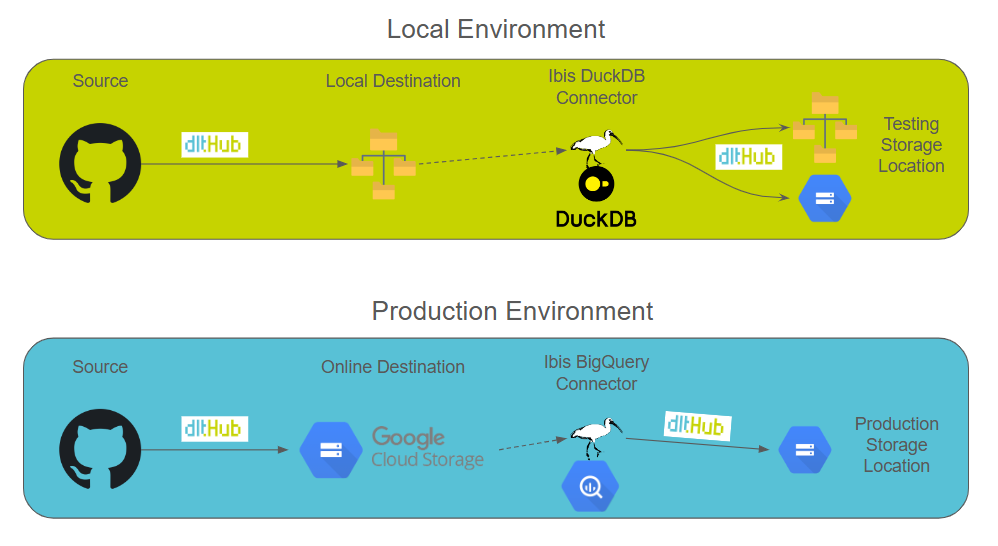